# <center><b><font color='blue'>Bitcoin Price Prediction</font></b></center>

<a name="1"></a>
## 1. Objetivos

Implementar N-beats.


Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture 
* Potentially get state of the art results on our problem 

<a name="2"></a>
## 2. Librerías necesarias

In [2]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
from tensorflow.keras.utils import plot_model

<a name="3"></a>
## 3. Helper Functions

In [4]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)


    
# se implementa MASE pues no existe en TF
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season
    
    
    
# make predictions
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions



# Evaluaci[on  de predicciones

# Create a function to take in model predictions and truth values and return evaluation metrics
# sirve para horizonte largo 1
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds_general(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}




# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    
    Recine arreglos de numpy
    Devuelve arreglos de numpy
    
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

# create windowed dataset
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    
    # drop nan values
    dataset_windowed.dropna(inplace=True)
    
    # convert to float32
    #dataset_windowed["Price"] = dataset_windowed["Price"].astype(np.float32)
    
    dataset_windowed = dataset_windowed.astype(np.float32)

    # return
    return dataset_windowed

<a name="4"></a>
## 4. Carga y pre-procesamiento de datos

In [5]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [6]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


#### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance 

In [8]:
HORIZON = 1
WINDOW_SIZE = 7 

In [9]:
bitcoin_windowed = create_windowed_dataset(bitcoin_prices,WINDOW_SIZE)

In [11]:
# Create X (windows) and y (horizons) features
X = bitcoin_windowed.drop("Price", axis=1)
y = bitcoin_windowed["Price"]

In [12]:
X_train, X_test, y_train, y_test = make_train_test_splits(X.values, y.values)
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [13]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

## 5. Implementando N-beats

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

Comenzaremos por implementar el bloque siguiente:



<img src='images/block_layer.png'></img>


In [14]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
            # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
          x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and the forecast from theta
        
        
        #print('theta',theta,'\n')
        #print('backcast',theta[:, :self.input_size],'\n')
        
        # usa backcast para predecir forecast ---> chequear!!
        
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [15]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [16]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [17]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}\n")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.2605159  -0.3641439  -0.26918805 -0.12260871 -0.58215106 -0.30434185
  0.6987624 ]

Forecast: 0.7047289609909058


#### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf 

In [24]:
# Values from N-BEATS paper
N_EPOCHS = 20 #5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks: 
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance) 

<img src='images/N-beatss.png'/>

!!!!!!!!!!! dibujo con explicacion mas detallada del codigo

In [25]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS, #N_EPOCHS
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)]
           
           )



Epoch 1/20
3/3 [==============================] - 73s 4s/step - loss: 1331.7614 - val_loss: 19914.0059 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 2202.2786 - val_loss: 154244.4375 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 5823.1973 - val_loss: 14387.4941 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 2375.2373 - val_loss: 9489.7334 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 1033.6495 - val_loss: 1162.2228 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 784.4066 - val_loss: 5387.0312 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 1729.8164 - val_loss: 5147.5811 - lr: 0.0010
Epoch 8/20
3/3 [==============================] - 6s 2s/step - loss: 1267.9858 - val_loss: 3568.5984 - lr: 0.0010
Epoch 9/20
3/3 [==============================] - 6s 2s/step - loss: 1585.2334 - val

In [26]:
# Evaluate N-BEats model on the test dataset
model.evaluate(test_dataset)

1/1 [==============================] - 1s 630ms/step - loss: 946.2611


946.2611083984375

In [27]:
# Make predictions with N-BEATS model
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 4s 4s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9332.203, 9245.723, 9264.503, 9151.543, 9083.337, 9013.927,
       8929.372, 8855.14 , 8827.286, 8753.624], dtype=float32)>

In [31]:
# Evaluate N-BEATS model preds
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 946.2611,
 'mse': 3017583.0,
 'rmse': 1737.1191,
 'mape': 4.2933154,
 'mase': 1.6623187}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

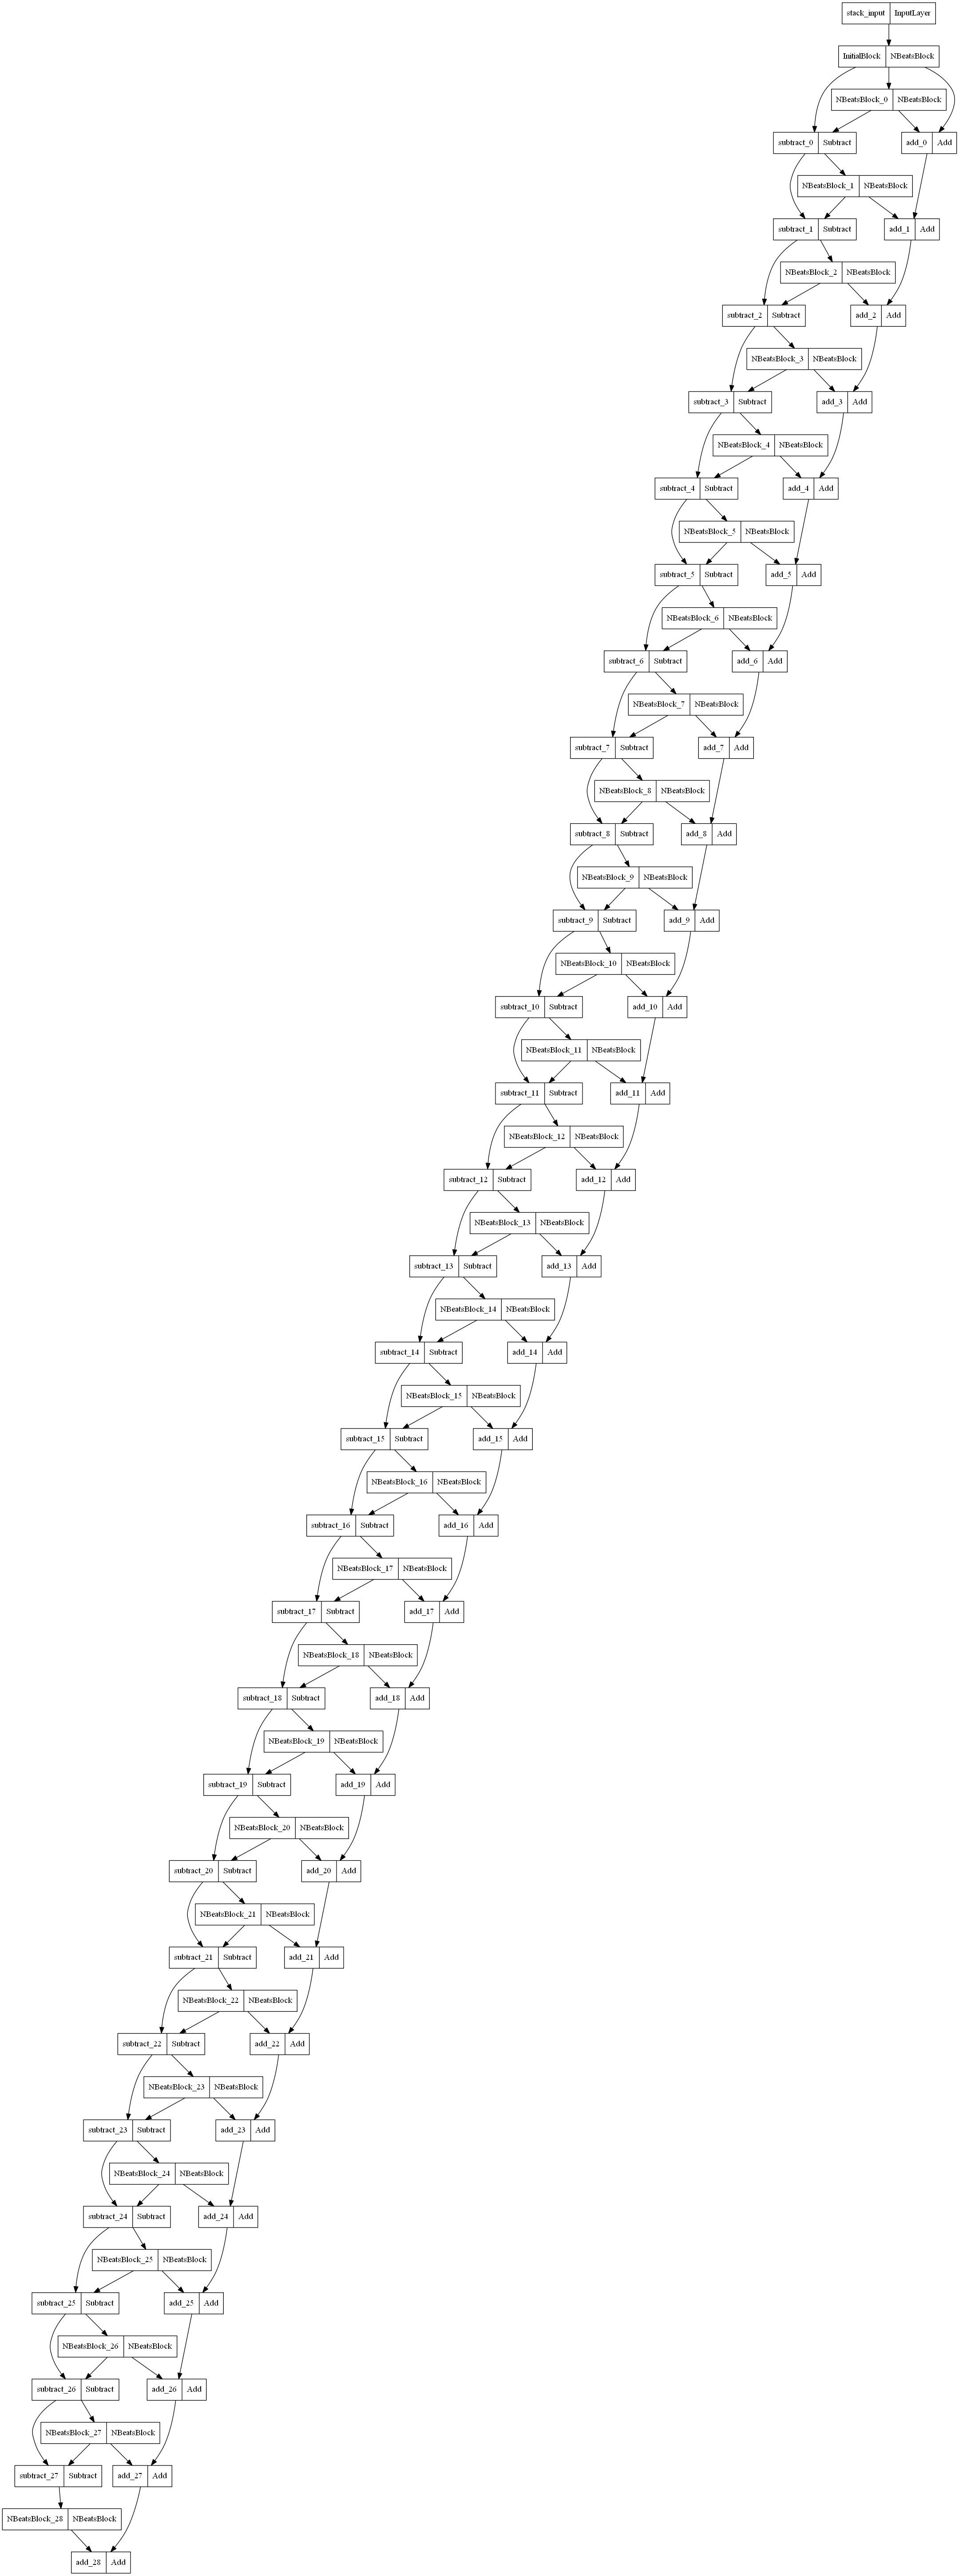

In [32]:
# Plot the N-BEATS model and inspect the architecture

plot_model(model)

## ANEXO

### Conexiones residuales

#### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [20]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [33]:
#https://torres.ai/api-funcional-de-keras/